
1. During the early days of the covid 19 pandemic, many scientists from arround the world turned to their prefered modeling tools to provide insight into how the pandemic might unfold and what actions governments should take. One particular model which made headlines around the globe was developed by a group at Imperial in the UK. This model was derived from an earlier 2005 model for Thailand to study how a mutated version of H5N1 avian flu might spread. In follow up work, the authors reparameterized this model for the UK to study possible deadly flu strains. Without going into the specifics of the imperial model, what can you say more theoretically about the strengths and weaknesses of using ABMs to study pandemic outbreaks at a country level? List 3 strenghts and 3 weaknesses.

There is a range of ways in which you can answer this question. What matters is that you build on the key characteristics of ABMs: local interaction amongst heterogenous agents. So an ABM can be used to study how a pandemic might arise out of local interactions. However, you need detailed microlevel data about your population (age, susceptability, travel patterns, etc.). The runtime of such a model will be huge. And the uncertainties will be massive because of the detailed microlevel data. It is thus also questionable whether you can make detailed predictions about how a pandemic will unfold. 

Possible strengths
1. Detailed representation of different spreading mechanisms (public spaces, public transport, work, schoolls, homes. This in turn enables explored in more detail the possible effects of targeted interventions (e.g. closing schools, reducing use of public transport). 
2. bottom up perspective is simple to understand, and key data required for ODE based models might become an emergent property in the ABM model. 
3. ABM enables encoding heterogeneity directly, rather than having to be decided on during modeling (i.e. how to compartmentalize your population). The bottom up perspective also enables encoding social networks more directly. 

Possible weaknesses
1. detailed micro data required
2. massive uncertainties in model outputs
3. massive runtime

if you are interested, check https://www.nature.com/articles/d41586-020-01003-6, https://doi.org/10.1287/mnsc.1070.0787, and the various entries in https://rofasss.org/tag/JASSS-Covid19-Thread/ for more perspectives on this topic.

2. The model below contains 5 errors. Fix the model. Carefull list each error, the line number and how you have changed it.

    1. happy is not incremented (line 18)
    2. datacollector should use model_reporters (line 56)
    3. inequality sign in line 66 is wrong way around
    4. use self.random instead of random (line 65, 66)
    5. inequality of meets threshold is the wrong way arround (line 124)



3. Below, the image shows an alternative implementation of the Schelling seggregation model using hexagonal tiling. If you were asked to implement this version of the model, how woud you do it?

<img src="fig_hex_300dpi.png" width="400">


The hexagonal tiling is a change in the space within which the agents are interacting. The most logical way to implement this, therefore, would be to use a hexagonal tile based space. This is actually provided already by mesa in the form of HexGrid.



In [1]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

from enum import Enum

class Color(Enum):
    RED = 1 # minority color
    BLUE = 2 # majority color

def count_happy(model):
    happy = 0
    for agent in model.schedule.agents:
        if agent.happy:
            happy + 1
    return happy

class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : float
                          fraction of differently colored neighbors
                          which is acceptable
    
    Attributes
    ----------
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=0.5, seed=None):
        super().__init__(seed=seed)
        self.density = density
        self.minority_fraction = minority_fraction

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.datacollector = DataCollector(model_reporters={'happy':count_happy})

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if random.random() < self.density:
                if random.random() >= self.minority_fraction:
                    agent_color = Color.RED
                else:
                    agent_color = Color.BLUE

                agent = SchellingAgent((x, y), self, agent_color, tolerance_threshold)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)


class SchellingAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : float
    
    Attributes
    ----------
    pos : tuple
    color : Color field
    tolerance_threshold : float
    happy : boolean
    
    """

    def __init__(self, pos, model, color, tolerance_threshold):
        super().__init__(pos, model)
        self.pos = pos
        self.color = color
        self.tolerance_threshold = tolerance_threshold
        self.happy = True
        
    def meets_threshold(self):
        different = 0
        neighborhood_iterator = self.model.grid.iter_neighborhood(self.pos, moore=True,
                                                                  radius=1)
        neighborhood_pos = [entry for entry in neighborhood_iterator]
        neighborhood_size = len(neighborhood_pos)
        
        neighborhood = self.model.grid.iter_cell_list_contents(neighborhood_pos)                
        
        for neighbor in neighborhood:
            if neighbor.color != self.color:
                different += 1
        
        meets_threshold = different > (self.tolerance_threshold * neighborhood_size)
        return meets_threshold

    def step(self):
        '''execute one step of the agent'''
        
        if not self.meets_threshold():
            self.model.grid.move_to_empty(self)
            self.happy = False
        else:
            self.happy = True
            
            
model = Schelling()
for _ in range(10):
    model.step()

4. A major structural uncertainty in the Schelling segregration model is what counts as the neighborhood of the model. Focus specifically on the number of ticks it takes for the model to reach equilibrium with a maximum of 100 ticks. Assume that the number of neighbors is fixed (and thus can include empty cells). In answering this question, first conceptually describe what needs to be done for answering this question, before implementing it. 
    
    1. How does the behavior of the model change depending on whether you are using von Neuman or Moore? 
    2.And what happens to the behavior of the model if you change the radius (1, 2, or 3) in case of a Moore neighborhood? 
    3. Offer an explanation for the results


This is quite a tricky question with a number of elements. 

1. we must record somehow the tick at which equilibirum is reached
2. we run 2 versions of the same model, one with von Neuman neighborhood and one with Moore. This however, requires changing the implicit constants in line 113 into settable attributes.

   The first step is to adapt the model to make answering this code easier. We make moore and radius attributes on the model which are set in the `agent.__init__`.
   The next step is to assess whether equilibrium is reached. Equilibrium is reached if all agents are happy. So we can compare count_happy with the total number of agents. Next, we can add this new model attribute to be collected by the datacollector.
   The final step is to perform 2 experiments. The first is comparing Moore to von Neuman neighborhood. The second is to compare a neighborhoodsize of 1, 2, and 3 given a Moore neighborhood.

In [2]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

from enum import Enum

class Color(Enum):
    RED = 1 # minority color
    BLUE = 2 # majority color

def count_happy(model):
    happy = 0
    for agent in model.schedule.agents:
        if agent.happy:
            happy += 1
    return happy


class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : float
                          fraction of differently colored neighbors
                          which is acceptable
    
    Attributes
    ----------
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=0.5, moore=True, radius=1,
                 seed=None):
        super().__init__(seed=seed)
        self.density = density
        self.minority_fraction = minority_fraction

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.n_happy = 0   
        self.t_equil = 100
        self.datacollector = DataCollector(model_reporters={'happy':'n_happy',
                                                             't_equil':'t_equil'})

        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < self.density:
                if self.random.random() <= self.minority_fraction:
                    agent_color = Color.RED
                else:
                    agent_color = Color.BLUE

                agent = SchellingAgent((x, y), self, agent_color, tolerance_threshold,
                                       moore=moore, radius=radius)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

        self.n_agents = self.schedule.get_agent_count()    

    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.n_happy = count_happy(self)
        
        # the second clause here is needed to avoid
        # changing t_equil after equilibrium is reached
        if (self.n_happy == self.n_agents) and (self.t_equil == 100):
            self.t_equil = self.schedule.time
        
        self.datacollector.collect(self)

class SchellingAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance|
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : float
    
    Attributes
    ----------
    pos : tuple
    color : Color field
    tolerance_threshold : float
    happy : boolean
    
    """

    def __init__(self, pos, model, color, tolerance_threshold, moore=True,
                radius=1):
        super().__init__(pos, model)
        self.pos = pos
        self.color = color
        self.tolerance_threshold = tolerance_threshold
        self.happy = True
        self.moore = moore
        self.radius = radius
        
    def meets_threshold(self):
        different = 0
        neighborhood_iterator = self.model.grid.iter_neighborhood(self.pos, moore=self.moore,
                                                                  radius=self.radius)
        neighborhood_pos = [entry for entry in neighborhood_iterator]
        neighborhood_size = len(neighborhood_pos)
        
        neighborhood = self.model.grid.iter_cell_list_contents(neighborhood_pos)        
        for neighbor in neighborhood:
            if neighbor.color != self.color:
                different += 1
        
        meets_threshold = different < round(self.tolerance_threshold * neighborhood_size)
        return meets_threshold

    def step(self):
        '''execute one step of the agent'''
        
        if not self.meets_threshold():
            self.model.grid.move_to_empty(self)
            self.happy = False
        else:
            self.happy = True
            

In [3]:
model = Schelling()
for _ in range(100):
    model.step()

model.datacollector.get_model_vars_dataframe()

,happy,t_equil
0,269,100
1,283,100
2,293,100
3,301,100
4,303,100
...,...,...
95,334,92
96,334,92
97,334,92
98,334,92


For doing the experiments, we first explore Moore versus von Neuman. We need to run the model for multiple replications because of stochastics. We can also explicitly control the random seed to ensure both models for each replication start from the same initial condition. So, the only difference between the runs is really own to the neighborhood function only. 

In [4]:
from collections import defaultdict

results = defaultdict(list)

for neighborhood in (('moore', True), ('neuman', False)):
    (name, boolean) = neighborhood
    for rep in range(50):
        model = Schelling(moore=boolean, seed=rep)
        for _ in range(100):
            model.step()

        data = model.datacollector.get_model_vars_dataframe()
        value = data.t_equil.min()
        results[name].append(value)

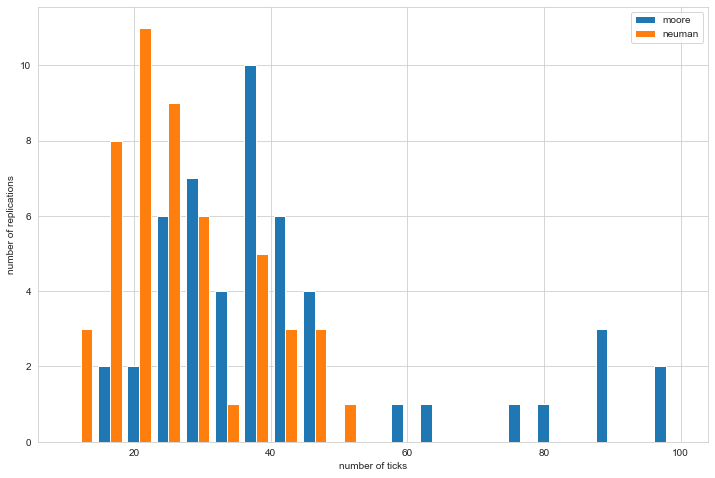

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.DataFrame(results)

fig, ax = plt.subplots()

ax.hist([data.iloc[:, 0], data.iloc[:, 1]], bins=21,
        label=data.columns.values)
ax.set_xlabel('number of ticks')
ax.set_ylabel('number of replications')
ax.legend()

plt.show()

we can take our analysis a step further. We can formally check if the 2 distributions are the same of different using a Kolmogorov Smirnov test as shown below. The very low p value suggests that the distributions are in fact quite different supporting the claim that Moore converges more quickly to equilibrium than von Neuman distance. 

In [6]:
from scipy.stats import ks_2samp

ks_2samp(data['moore'], data['neuman'])

KstestResult(statistic=0.48, pvalue=1.3867885687360081e-05)

# different radius sizes

In [ ]:
from collections import defaultdict

results = defaultdict(list)

for radius in range(1, 4):
    for rep in range(50):
        model = Schelling(moore=True, radius=radius, seed=rep)
        for _ in range(100):
            model.step()

        data = model.datacollector.get_model_vars_dataframe()
        value = data.t_equil.min()
        results[radius].append(value)

In [ ]:
data = pd.DataFrame(results)

fig, ax = plt.subplots()

ax.hist([data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2]], bins=21,
        label=data.columns.values)
ax.set_xlabel('number of ticks')
ax.set_ylabel('number of replications')
ax.legend()

plt.show()

Looking across both experiments, we see that the larger the neighborhood is that is being considered, the slower the model is in reaching equilibrium. Why might this happen? Basically, the minority agents will struggle to meet their tolerance threshold if neighborhood size increases. Thus they are less likely to be happy and wiil continue to keep jumping around. 